# MNIST check

In [1]:
using Pkg
using Plots
using DelimitedFiles
using BenchmarkTools

In [2]:
Pkg.activate("../Sampling/")
using Sampling
Pkg.activate("../../GaussianEP/")
using GaussianEP

  Activating environment at `~/GaussianEP/Sampling/Project.toml`
  Activating environment at `~/GaussianEP/Project.toml`


## (Pv,Ph) = (Bernoulli, Bernoulli)

In [3]:
using JLD2

mean_data = readdlm("../MNIST/mean.txt", '\t', Float64, '\n')
covv_data = readdlm("../MNIST/corr.txt", '\t', Float64, '\n')
data_EP = load("../MNIST/res_BerRBM_rh8_w0bim_adagrad_SGD_epTRBL.jld2");
w_EP = data_EP["res"].weights;


┌ Warning: type parameters for NamedTuple{(:weights, :likelihood, :state, :opt, :grad),Tuple} do not match type NamedTuple in workspace; reconstructing
└ @ JLD2 /home/disat/amuntoni/.julia/packages/JLD2/sFiXk/src/data/reconstructing_datatypes.jl:430
┌ Warning: type epRBM.Adagrad{Float64,Int64} does not exist in workspace; reconstructing
└ @ JLD2 /home/disat/amuntoni/.julia/packages/JLD2/sFiXk/src/data/reconstructing_datatypes.jl:450


In [4]:

N,M = size(w_EP)

rhov = 0.8677
rhoh = 0.8
Pv = BinaryPrior(0.0, 1.0, rhov)
Ph = BinaryPrior(0.0, 1.0, rhoh)
y = zeros(N+M)

P0 = vcat([Pv for i = 1:N], [Ph for i = 1:M]);
H = [GaussianEP.TermRBM(w_EP,y,1.0)];

out_ep = expectation_propagation(H,P0, nprint = 1000, maxiter = 10000, damp = 0.99, epsconv = 1e-5);



it: 1000 Δav: 0.0001569795143512298 Δgrad: 0.0
it: 2000 Δav: 0.00028957215786765134 Δgrad: 0.0
it: 3000 Δav: 9.335860710768529e-5 Δgrad: 0.0
it: 4000 Δav: 1.4142016602047836e-5 Δgrad: 0.0


In [8]:
using BoltzmannMachines
#data_bm = load("../MNIST/winf_fields_BerRBM.jld2")
data_bm = load("../MNIST/bm_rbm_cdstep10_batchsize500.jld2")
w_BM = data_bm["rbm"].weights
N,M = size(w_BM)
y = zeros(N+M,)
rhov_BM = 1.0 ./ (1.0 .+ exp.(data_bm["rbm"].visbias));
rhoh_BM = 1.0 ./ (1.0 .+ exp.(data_bm["rbm"].hidbias));

Pv = [BinaryPrior(0.0,1.0,rhov_BM[i]) for i = 1:N]
Ph = [BinaryPrior(0.0,1.0,rhoh_BM[i]) for i = 1:M]

P0_BM = vcat(Pv,Ph);

H_BM = GaussianEP.TermRBM(zeros(N,M),y,1.0);
beta_min = 0.01
beta_max = 1.0
niter = 200
step = (beta_max - beta_min) / niter
beta = beta_min
out_BM = nothing

#out_BM_plain = expectation_propagation([H_BM],P0_BM,nprint = 100, damp= 0.995, epsconv = 5e-4, maxiter = 3000, state = nothing);

for iter = 1:niter+1
    H_BM.w .= beta * w_BM
    println(beta, " ", sum(H_BM.w - w_BM))
    if iter == 1
        out_BM = expectation_propagation([H_BM],P0_BM,nprint = 1000, damp= 0.99, epsconv = 1e-2, maxiter = 10000, state = nothing);
    else
        out_BM = expectation_propagation([H_BM],P0_BM,nprint = 1000, damp= 0.99, epsconv = 1e-2, maxiter = 10000, state = out_BM[1].state);
    end
    beta += step
end 



0.01 9344.298815722079
0.01495 9297.577321643468
0.0199 9250.855827564857
0.02485 9204.134333486247
0.0298 9157.412839407636
0.03475 9110.691345329025
0.0397 9063.969851250416
Infinite Z

Infinite Z

Infinite Z

Infinite Z

Infinite Z

Infinite Z

Infinite Z

Infinite Z

0.044649999999999995 9017.248357171806
Infinite Z

Infinite Z

Infinite Z

Infinite Z

Infinite Z

Infinite Z

Infinite Z

Infinite Z

Infinite Z

Infinite Z

Infinite Z

Infinite Z

0.04959999999999999 8970.526863093195
0.05454999999999999 8923.805369014586
0.05949999999999998 8877.083874935974
0.06444999999999998 8830.362380857365
0.06939999999999998 8783.640886778754
0.07434999999999997 8736.919392700143
0.07929999999999997 8690.197898621533
0.08424999999999996 8643.476404542924
0.08919999999999996 8596.754910464311
0.09414999999999996 8550.033416385702
0.09909999999999995 8503.311922307093
0.10404999999999995 8456.590428228481
0.10899999999999994 8409.868934149872
0.11394999999999994 8363.147440071261
0.11889999999

In [9]:
sum(H_BM.w .- w_BM)


-1.4663534920455995e-11

In [10]:
out_BM[1].av

1184-element Vector{Float64}:
 0.000121971185964838
 0.00015759531921113093
 0.000146115385172111
 0.00010122186467669723
 0.00012440585447276854
 0.00020455337899988815
 0.00024252367193079645
 0.00016606815004132483
 0.0001233176536901662
 0.00012132640813087392
 0.00011154207054804425
 0.0001372394477406824
 0.00011458156981019609
 ⋮
 0.443541474892308
 0.022873800027622317
 0.17451285686557272
 0.7091245566549893
 0.3393042132582981
 0.8408490854454519
 0.9887488543768665
 0.8617591787406614
 0.035084327587484886
 0.30119338610208524
 0.00014847792309814932
 0.15378196196177477

In [11]:
w_BM2 = data_bm["rbm"].weights

784×400 Matrix{Float64}:
 -0.078641    -0.010966    -0.0734594   …  -0.0466692  -0.0989353
 -0.0696068   -0.0689292    0.00613992     -0.10315    -0.0615087
 -0.0884855   -0.0187172   -0.00686394     -0.0548097  -0.032981
 -0.087832    -0.0514673   -0.0328553      -0.0360496  -0.00328218
 -0.0788077   -0.0708524   -0.055869       -0.0949052  -0.08774
 -0.081285    -0.00983683  -0.0631858   …  -0.108426   -0.108703
 -0.0793047   -0.0509522   -0.0301811      -0.118712   -0.0411659
 -0.0468901   -0.0289778   -0.0430899      -0.0932385  -0.0443756
 -0.0942849   -0.115297    -0.0662865      -0.0694818  -0.0709273
 -0.0855191   -0.0696982   -0.0600286      -0.0416222  -0.0731242
 -0.100196    -0.04513     -0.0553107   …  -0.0712551  -0.0823161
 -0.0696272   -0.0359742   -0.0990316      -0.0425158  -0.0666148
 -0.0757158   -0.0862829   -0.0266376      -0.0528125   0.00870909
  ⋮                                     ⋱              
  0.0973129    0.0848507   -0.0769815      -0.079196   -0.13620

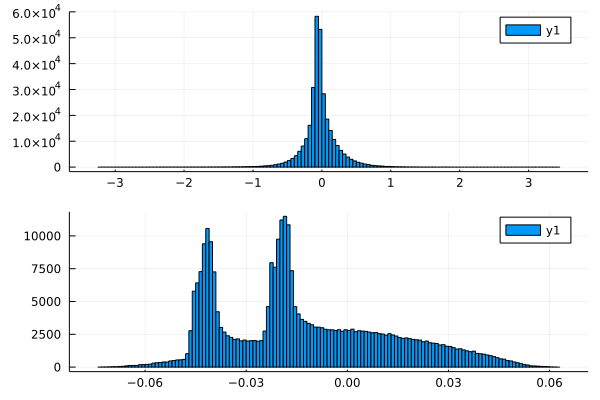

In [12]:
#data_bm = load("../MNIST/bm_rbm_cdstep10_batchsize500.jld2")
#w_BM = data_bm["rbm"].weights
p1 = histogram(vec(w_BM), nbins = 200, mode = :probability)
p2 = histogram(vec(w_EP), nbins = 200, mode = :probability)
#p2 = plot(vec(H_BM.w),vec(w_BM), seriestype= :scatter)
l = @layout [a;b]
plot(p1,p2, layout = l)

In [13]:
using Random


#biasv_ep = log((1.0 - rhov_BM)/rhov_BM)
#biash_ep = log((1.0 - rhoh_BM)/rhoh_BM)
rbm_bm = data_bm["rbm"]
#rbm_ep = BernoulliRBM(w_EP, fill(biasv_ep, N), fill(biash_ep, M))
#[particle_ep = BoltzmannMachines.initparticles(rbm_ep, 1, biased=true)
particle_bm = BoltzmannMachines.initparticles(rbm_bm, 1, biased=true)

#typeof(rbm_bm)
Nconf = 10000
Neq = 200000
#samples_ep = zeros(Nconf, N)
samples_bm = zeros(Nconf, N)

hidden_bm = zeros(Nconf,M)
#hidden_ep = zeros(Nconf,M)

myseed = 19
Random.seed!(myseed)
#gibbssample!(particle_ep, rbm_ep, Neq)
gibbssample!(particle_bm, rbm_bm, Neq)
for i = 1:Nconf

    #gibbssample!(particle_ep, rbm_ep, 1)
    gibbssample!(particle_bm, rbm_bm, 1)
    #samples_ep[i,:] = particle_ep[1]
    samples_bm[i,:] = particle_bm[1]
    #hidden_ep[i,:] = particle_ep[2]
    hidden_bm[i,:] = particle_bm[2]
end


In [14]:

Pv_mc = [Sampling.BinaryPrior(0.0,1.0,rhov_BM[i]) for i = 1:N]
Ph_mc = [Sampling.BinaryPrior(0.0,1.0,rhoh_BM[i]) for i = 1:M]

P0mc= vcat(Pv_mc,Ph_mc);

mc_out = Sampling.MC_sim(w_BM, P0mc, Neq, 0.0, N_iter = 10000)
av_mc, va_mc, cov_mc = Sampling.compute_statistics(mc_out, N, M);

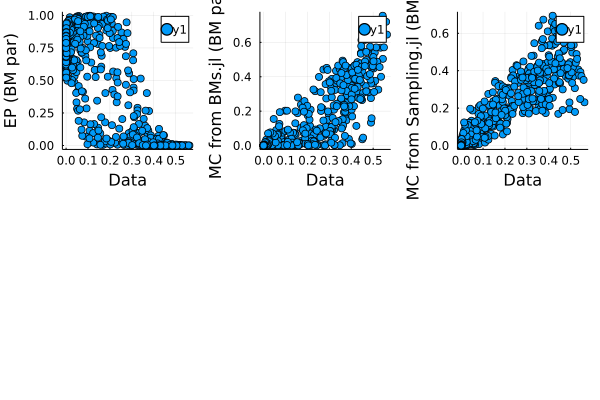

In [ ]:
mean_bm_mc = mean(samples_bm, dims=1)
p1 = plot(mean_data, out_BM[1].av[1:N], seriestype = :scatter, xlabel = "Data", ylabel = "EP (BM par)")
p2 = plot(mean_data, vec(mean_bm_mc), seriestype = :scatter, xlabel = "Data", ylabel = "MC from BMs.jl (BM par)")
p3 = plot(mean_data, av_mc, seriestype = :scatter, xlabel = "Data", ylabel = "MC from Sampling.jl (BM par)")
l = @layout  [a{0.4h} b{0.4h} c{0.4h}]
plot(p1, p2, p3, layout = l)

In [ ]:
using Statistics
covv_bm_mc = cov(samples_bm)
covv_ep_mc = cov(samples_ep)
mean_bm_mc = mean(samples_bm, dims=1)
mean_ep_mc = mean(samples_ep, dims=1)

p1 = plot(out_ep[1].av[1:N], vec(mean_ep_mc), seriestype = :scatter, xlabel = "EP (EP)", ylabel = "EP (MC)")
p2 = plot(out_BM[1].av[1:N], vec(mean_bm_mc), seriestype = :scatter, xlabel = "BM (EP)", ylabel = "BM (MC)")
p3 = plot(mean_data, vec(mean_ep_mc), seriestype = :scatter, xlabel = "Data", ylabel = "EP (MC)")
p4 = plot(mean_data, vec(mean_bm_mc), seriestype = :scatter, xlabel = "Data", ylabel = "BM (MC)")
l = @layout [a b ; c d]
plot(p1,p2,p3,p4, layout = l)

LoadError: UndefVarError: samples_ep not defined

In [ ]:
Nconf = 10000
Ndig = 10000
#digits_ep = zeros(Ndig, N)
digits_bm = zeros(Ndig, N)
L = convert(Int64,sqrt(N))

p1 = []
p2 = []

for i = 1:Ndig
    #digits_ep[i,:] = samplevisible(rbm_ep, hidden_ep[idx,:])
    digits_bm[i,:] = samplevisible(rbm_bm, hidden_bm[i,:])
    #p1 = vcat(p1, heatmap(reshape(mean(digits_ep, dims=1), L, L), aspect_ratio = :equal, yflip = false))
    p2 = vcat(p2, heatmap(reshape(mean(digits_bm, dims=1), L, L), aspect_ratio = :equal, yflip = false))

end



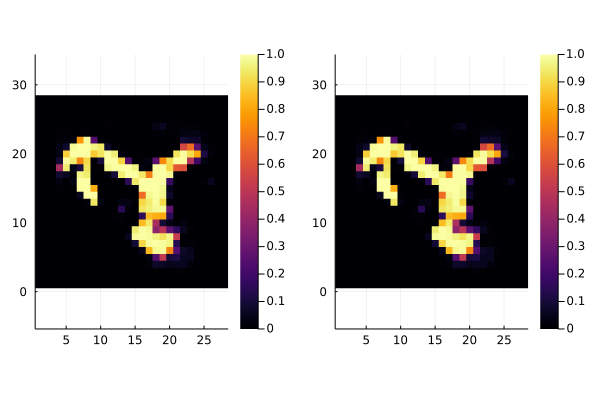

In [ ]:

idx = 90
plot(p2[idx], p2[idx])

In [ ]:
covv_ep = zeros(N,N)
for i = 1:N, j = i+1:N
	covv_ep[i,j] = out_ep.state.Σ[i,j] + out_ep.state.av[i] * out_ep.state.av[j]
	covv_ep[j,i] = covv_ep[i,j]
end

va_data = zeros(N,)
for i = 1:N
	va_data[i] = covv_data[i,i] - mean_data[i] * mean_data[i]
	covv_data[i,i] = NaN
end

covv_bm = zeros(N,N)
for i = 1:N, j = i+1:N
	covv_bm[i,j] = out_BM.state.Σ[i,j] + out_BM.state.av[i] * out_BM.state.av[j]
	covv_bm[j,i] = covv_bm[i,j]
end


In [ ]:
p = Plots.plot(mean_data, mean_data, aspect_ratio = :equal, seriestype = :scatter, label = "x = y", legend = :topleft, xlabel= "Data av")
p = Plots.plot!(mean_data, out_ep.av[1:N], aspect_ratio = :equal, seriestype = :scatter, label = "EP means", legend = :topleft, xlabel= "Data av")
p1 = Plots.plot(mean_data, mean_data, aspect_ratio = :equal, seriestype = :scatter, label = "x = y", legend = :topleft, xlabel= "Data av")
p1 = Plots.plot!(mean_data, out_BM.av[1:N], seriestype = :scatter, label = "BM means", legend = :topleft, xlabel= "Data av")
p2 = Plots.plot(out_BM.av[1:N], out_ep.av[1:N], seriestype = :scatter, label = "Av", legend = :topleft, xlabel = "BM", ylabel = "EP")
l = @layout [a{0.3h} b{0.3h} c{0.3h}]
Plots.plot(p, p1,p2, layout = l)

In [ ]:
p = Plots.plot(va_data, va_data, aspect_ratio = :equal, seriestype = :scatter, label = "x = y", legend = :topleft, xlabel= "Data var")
p = Plots.plot!(va_data, out_ep.va[1:N], aspect_ratio = :equal, seriestype = :scatter, label = "EP vars", legend = :topleft, xlabel= "Data var")
p1 = Plots.plot(va_data, va_data, aspect_ratio = :equal, seriestype = :scatter, label = "x = y", legend = :topleft, xlabel= "Data var")
p1 = Plots.plot!(va_data, out_BM.va[1:N], seriestype = :scatter, label = "BM vars", legend = :topleft, xlabel= "Data var")
p2 = Plots.plot(out_BM.va[1:N], out_ep.va[1:N], seriestype = :scatter, label = "Vars", legend = :topleft, xlabel = "BM", ylabel = "EP")
l = @layout [a{0.3h} b{0.3h} c{0.3h}]
Plots.plot(p, p1,p2, layout = l)

In [ ]:
vcovv_data = vec(covv_data)
vcovv_ep = vec(covv_ep)
vcovv_bm = vec(covv_bm)

p = Plots.plot(vcovv_data, vcovv_data, aspect_ratio = :equal, seriestype = :scatter, label = "x = y", legend = :topleft, xlabel= "Data cov(v,v)")
p = Plots.plot!(vcovv_data, vcovv_ep, aspect_ratio = :equal, seriestype = :scatter, label = "EP covv", legend = :topleft, xlabel= "Data cov(v,v)")
p1 = Plots.plot(vcovv_data, vcovv_data, aspect_ratio = :equal, seriestype = :scatter, label = "x = y", legend = :topleft, xlabel= "Data cov(v,v)")
p1 = Plots.plot!(vcovv_data, vcovv_bm, seriestype = :scatter, label = "BM covv", legend = :topleft, xlabel= "Data cov(v,v)")
p2 = Plots.plot(vcovv_bm, vcovv_ep, seriestype = :scatter, label = "Cov (v,v)", legend = :topleft, xlabel = "BM", ylabel = "EP")
l = @layout [a{0.3h} b{0.3h} c{0.3h}]
Plots.plot(p, p1,p2, layout = l)



In [ ]:
writedlm(open("../MNIST/covv_bm.dat", "w"), vec(covv_bm))
writedlm(open("../MNIST/covv_ep.dat", "w"), vec(covv_ep))
writedlm(open("../MNIST/covv_data.dat", "w"), vec(covv_data))
size(vec(covv_bm))